In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from ordinalmodel.ordinal_model import OrdinalRandomForestClassifier
from ordinalmodel.ordinal_measures import ranked_probability_score
import ordinalmodel.utils as utils

# 1. Load dataset

#### (1) Student admission dataset

In [12]:
# Student admission dataset
url = "https://stats.idre.ucla.edu/stat/data/ologit.dta"
data_student = pd.read_stata(url)
data_X = data_student[['pared', 'public', 'gpa']]
data_Y = data_student['apply']
# Data type of target variable ('data_Y'): CategoricalDtype(categories=['unlikely', 'somewhat likely', 'very likely'], ordered=True, categories_dtype=object)

# Convert ordinal target into numeric target
data_Y = utils.convert_target(data_Y, object_type='int')


print('\nShape of data:', data_X.shape, data_Y.shape,
      '\nDistribution of target variables:', data_Y.value_counts().sort_index().to_dict())


Shape of data: (400, 3) (400,) 
Distribution of target variables: {0: 220, 1: 140, 2: 40}


#### (2) Wine quality dataset

In [13]:
# Wine quality dataset
from test_data.load_dataset import load_dataset
data_X, data_Y = load_dataset('wine_quality', preprocess=True, split_target=True)

# Convert numerical variable into ordinal variable
data_Y = utils.convert_target(
    data_Y, object_type='category', 
    mapper={3 : 'Low', 4 : 'Low', 5 : 'Low', 6 : 'Medium', 7 : 'Medium', 8 : 'High', 9 : 'High'})
data_Y = utils.convert_target(data_Y, object_type='int')


print('\nShape of data:', data_X.shape, data_Y.shape,
      '\nDistribution of target variables:', data_Y.value_counts().sort_index().to_dict())

['Low', 'Medium', 'High']

Shape of data: (6497, 12) (6497,) 
Distribution of target variables: {0: 2384, 1: 3915, 2: 198}


#### Split data into train and test sets

In [14]:
# split data into train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.3, random_state=42, stratify=data_Y)

print('\nShape of train data:', train_X.shape, train_Y.shape,
      '\nShape of test data:', test_X.shape, test_Y.shape,
      '\nDistribution of train target variables:', train_Y.value_counts().sort_index().to_dict(),
      '\nDistribution of test target variables:', test_Y.value_counts().sort_index().to_dict())


Shape of train data: (4547, 12) (4547,) 
Shape of test data: (1950, 12) (1950,) 
Distribution of train target variables: {0: 1668, 1: 2740, 2: 139} 
Distribution of test target variables: {0: 716, 1: 1175, 2: 59}


# 2. Random Forest

## 2.1 Ordinal Random Forest Classification

#### (1) Ordinal Random Forest

In [15]:
model = OrdinalRandomForestClassifier(
    probability_joint_type = 'independent',
    model_params_kwargs = {
        'n_estimators': 500, 
        'class_weight': 'balanced_subsample',
        'max_depth': 8})
model.fit(train_X, train_Y)

# Predict
# predict = model.predict(data_X)
# predict_prob = model.predict_prob(data_X)
# print(np.sum(np.abs(predict_prob.sum(axis=1) - 1)))


utils.print_performance(train_Y, model.predict(train_X))
print('Ranked Probability Score:', ranked_probability_score(train_Y.values, model.predict_proba(train_X)), )

utils.print_performance(test_Y, model.predict(test_X))
print('Ranked Probability Score:', ranked_probability_score(test_Y.values, model.predict_proba(test_X)), )


Accuracy: 0.812 
Balanced accuracy: 0.88 
Kappa: 0.651 
Macro F1: 0.746
Ranked Probability Score: 0.15422677229398118

Accuracy: 0.714 
Balanced accuracy: 0.668 
Kappa: 0.463 
Macro F1: 0.596
Ranked Probability Score: 0.2012577770486077


#### (2) Ordinal target to multiple binary targets

In [16]:
# check the function convert the ordinal target into binary target (model.create_ordinal_target)
data_Y_info = pd.concat(
    [data_Y.rename('Y label', inplace=False),
     pd.DataFrame(model.create_ordinal_target(data_Y.values),
         index = data_Y.index, columns = [f'Y<={i}' for i in range(model.n_classes_-1)])],
    axis=1)

assert np.all(data_Y_info['Y<=1'].values >= data_Y_info['Y<=0'].values)
# assert np.all(data_Y_info['Y label'] == data_Y_info[['Y<=0', 'Y<=1']].sum(axis=1))

data_Y_info.sample(5)

,Y label,Y<=0,Y<=1
5892,0,1,1
1936,1,0,1
5612,0,1,1
1422,0,1,1
1465,0,1,1


#### (3) Feature importance

<Axes: >

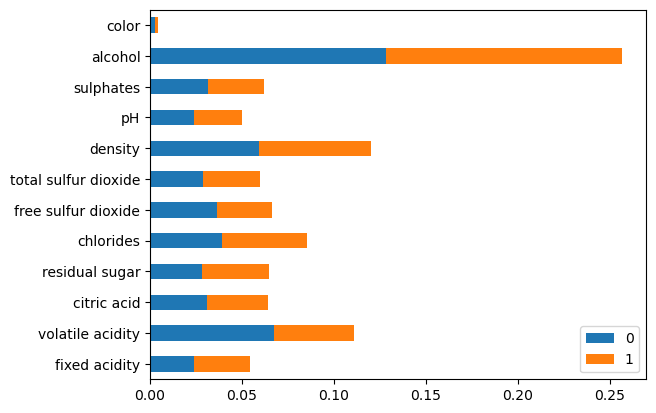

In [17]:
# Feature importance
feat_imp = pd.DataFrame(model.feature_importances_, columns=model.classes_[:-1], index=data_X.columns)
feat_imp.plot.barh(stacked=True)

In [18]:
# (n_samples, n_classes-1), the probability directly derived from the binary model
prob_raw         = model._predict_proba_raw(test_X.values)
# (n_samples, n_classes), the joint probability based on independent assumption
prob_independent = model._predict_proba_independent_joint(test_X.values)
# (n_samples, n_classes), the joint probability based on conditional assumption
prob_conditional = model._predict_proba_conditional_joint(test_X.values)

#### Random Forest Classification


Accuracy: 0.814 
Balanced accuracy: 0.877 
Kappa: 0.648 
Macro F1: 0.787
Ranked Probability Score: 0.1578338556940552

Accuracy: 0.734 
Balanced accuracy: 0.667 
Kappa: 0.483 
Macro F1: 0.636
Ranked Probability Score: 0.1968845614291283


<Axes: >

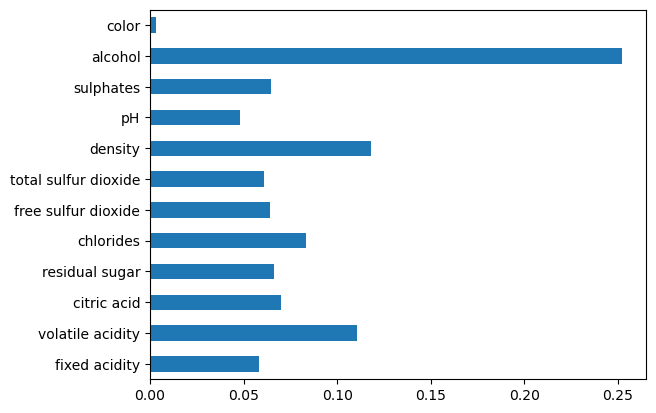

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500, 
    max_depth=8,
    class_weight='balanced_subsample')
model.fit(train_X, train_Y)


# Model performance
utils.print_performance(train_Y, model.predict(train_X))
print('Ranked Probability Score:', ranked_probability_score(train_Y.values, model.predict_proba(train_X)), )

utils.print_performance(test_Y, model.predict(test_X))
print('Ranked Probability Score:', ranked_probability_score(test_Y.values, model.predict_proba(test_X)), )


# Feature importance
feat_imp = pd.Series(model.feature_importances_, index=data_X.columns)
feat_imp.plot.barh()